# Project 1
MAE 256

Lysha Matsunobu

In [2]:
# import packages
import time, math, random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from cycler import cycler
from matplotlib import colors as mcolors

# Supporting function definitions

In [3]:
def getAngle(x,y):
    # get angle between vectors x and y
    # x and y are given in coordinate from same basis
    dot = np.dot(x,y)
    x_mag = np.sqrt((x*x).sum()) # x-vector magnitude
    y_mag = np.sqrt((y*y).sum()) # y-vector magnitude
    cos_angle = dot / x_mag / y_mag # cosine of angle between x and y
    angle = np.arccos(cos_angle)
    return angle

# find coordinates defining A2
def getA2coords(A2_x,A2_y,distance,A=45,B=60):
    # A and B are given in degres. alpha and beta are radian values
    alpha = 2*np.pi*(B-A)/360

    # delta from A2 origin to corner in ex, ey, ez defined by surface 2 orientation
    de1 = np.array([-(A2_x/2), (A2_y/2), 0])
    de2 = np.array([-(A2_x/2), -(A2_y/2), 0])
    de3 = np.array([(A2_x/2), -(A2_y/2), 0])
    de4 = np.array([(A2_x/2), (A2_y/2), 0])

    # transformation e -> r
    aa = (np.sin(alpha)*np.sin(alpha))+(np.cos(alpha)*np.cos(alpha))
    A  = np.matrix( ((0.,np.cos(alpha),np.sin(alpha)), (aa, 0., 0.), (0., np.sin(alpha),-np.cos(alpha))) )
    Ainv = np.linalg.inv(A) # inverse of A

    de1_in_r = np.dot(Ainv,de1)
    de2_in_r = np.dot(Ainv,de2)
    de3_in_r = np.dot(Ainv,de3)
    de4_in_r = np.dot(Ainv,de4)

    xy_delta = np.sqrt(0.5*np.power(distance,2)) # calculate length offsets
    origindelta = np.array([0,xy_delta,xy_delta]) # vector from A1 origin to A2 origin in rx, ry, rz

    # coordinates of A2 in rx, ry, rz
    e1_r = de1_in_r + origindelta
    e2_r = de2_in_r + origindelta
    e3_r = de3_in_r + origindelta
    e4_r = de4_in_r + origindelta
    
    return e1_r,e2_r,e3_r,e4_r

def getAnglePairs(A1corner,A2corner):
    # find the theta and phi to get from an A1 corner to an A2 corner
    o_phi_ref = np.array([10,A1corner[1],0]) # origin to phi=0 from corner vector 
    o_theta_ref = np.array([A1corner[0],A1corner[1],10]) # origin to zenith=0 over corner vector 
    
    rx_ref_vec = np.array([1,0,0])
    rz_ref_vec = np.array([0,0,1])
    
    topoint_phi = np.array([A2corner[0],A2corner[1],0]) # set the z-component to zero, project onto xy-plane; origin to projected corner
    topoint_theta = -1*A1corner + A2corner # A1corner to A2corner = corner to origin + origin to A2corner 
    
    phi = getAngle(rx_ref_vec,topoint_phi)
    theta = getAngle(rz_ref_vec,topoint_theta)
    return phi, theta

def getQfromF(F12,sidelength):
    sigma = 5.67E-08
    T=1000
    A1 = sidelength**2
    Eb1 = sigma*T**4
    Q = A1*F12*Eb1
    return Q

def getbookQ(sidelength):
    # sidelength should be given in [m]
    R=0.1 #10cm
    sigma = 5.67E-08
    T=1000
    Eb1 = sigma*T**4
    A1  = sidelength**2
    A2  = A1
    I   = Eb1/np.pi
    bookF12 = (A2*np.cos(45*2*np.pi/360)*np.cos(60*2*np.pi/360))/(np.pi*R**2)
    bookQ   = A1*Eb1*bookF12
    return bookF12, bookQ

# used in geometry plotting
def cc(ncolors):
    return mcolors.to_rgba(ncolors, alpha=1)

# F12 = findF12(N,sidelength)
Call this function to run Monte Carlo simulation

In [4]:
def findF12(N,sidelength):
    ## 1. DEFINE GEOMETRY ------------------------------------------
    N = int(N)

    A1_x = sidelength # surface 1 length in x [cm]
    A1_y = A1_x       # surface 1 length in y [cm]
    A2_x = A1_x       # surface 2 length in x [cm]
    A2_y = A2_x       # surface 2 length in y [cm]

    A1zenith = 45 # zenith angle from A1 origin to A2 origin
    A2zenith = 60 # zenith angle form A2 origin to A1 origin
    distance = 10 # [cm] distance between surfaces 1 and 2
    step_length = distance # define a step size to create direction vector

    ## 2. SAMPLE PHOTONS ------------------------------------------
    x0     = np.random.random(N)*(A1_x) + (-A1_x/2) # starting point in x
    y0     = np.random.random(N)*(A1_y) + (-A1_y/2) # starting point in y
    z0     = 0                                      # starting point in z
    theta0 = np.arcsin(np.sqrt(np.random.random(N))) # [rad]
    phi0   = 2*np.pi*np.random.random(N)             # [rad]

    rx = np.sin(theta0)*np.cos(phi0) # x-component of direction vector
    ry = np.sin(theta0)*np.sin(phi0) # y-component of direction vector
    rz = np.cos(theta0) # z-component of direction vector

    # Track a step change (used in finding intersection)
    x1 = x0 + rx*step_length
    y1 = y0 + ry*step_length
    z1 = z0 + rz*step_length

    ## 3. CHECK & COUNT ------------------------------------------
    # create dataframe of x0 positions, directions, and x1 positions (after 1 step change)
    df = pd.DataFrame({'x0':x0,'y0':y0,'z0':z0,'theta':theta0,'phi':phi0,'x1':x1,'y1':y1,'z1':z1})
    # get coordinates in the r-basis (origin basis) of the corners of surface A2
    e1_r,e2_r,e3_r,e4_r = getA2coords(A2_x,A2_y,distance,45,60)
    # A1 origin to corner 1
    A1c1 = np.array([(A1_x/2),(A1_y/2),0])
    A1c2 = np.array([(A1_x/2),-(A1_y/2),0])
    A1c3 = np.array([-(A1_x/2),-(A1_y/2),0])
    A1c4 = np.array([-(A1_x/2),(A1_y/2),0])
    # vector from A1 origin to A2 corner
    A2c1 = np.array(e1_r[0])[0]
    A2c2 = np.array(e2_r[0])[0]
    A2c3 = np.array(e3_r[0])[0]
    A2c4 = np.array(e4_r[0])[0]
    # run loop to find max and min thetas and phis
    A1corners = [A1c1,A1c2,A1c3,A1c4]
    A2corners = [A2c1,A2c2,A2c3,A2c4]
    
    # check the range of feasible angles
    phis   = np.empty([4, 4])
    thetas = np.empty([4, 4])
    i = 0
    # run nested for loop to check phi and theta of each pair of corners
    for a1c in A1corners:
        j = 0
        for a2c in A2corners:
            phis[i,j], thetas[i,j] = getAnglePairs(a1c,a2c)
            j+=1
        i+=1
    theta_max = np.amax(thetas)
    theta_min = np.amin(thetas)
    phi_max = np.amax(phis)
    phi_min = np.amin(phis)
    # eliminate photons that will not hit (check min and max theta and min and max phi)
    df = df[(df.theta>=theta_min)&(df.theta<=theta_max)&(df.phi>=phi_min)&(df.phi<=phi_max)]

    # find the range in x and y coordinates that define the plane of A2 (given (x,y), z is defined)
    xs = np.array([e1_r[0,0], e2_r[0,0], e3_r[0,0], e4_r[0,0]])
    ys = np.array([e1_r[0,1], e2_r[0,1], e3_r[0,1], e4_r[0,1]])
    xMin = np.amin(xs)
    xMax = np.amax(xs)
    yMin = np.amin(ys)
    yMax = np.amax(ys)
    
    # define the plane of A2 by three of its corners -> two vectors
    p0 = A2c1
    p1 = A2c2
    p2 = A2c3
    p01 = p1-p0
    p02 = p2-p0
    crossp = np.cross(p01,p02) # creates normal vector to surface A2
    # define the line of the photon as the vector I_ab
    I_a = np.array([df.x0.values,df.y0.values,df.z0.values])
    I_b = np.array([df.x1.values,df.y1.values,df.z1.values])
    I_ab = I_b - I_a
    Iap = np.transpose(np.subtract(np.transpose(I_a),p0))
    t = np.dot(crossp,Iap) / np.dot(np.transpose(-I_ab),crossp)
    intersection = I_a + I_ab*t
    intersect = (intersection[0]<=xMax)&(intersection[0]>=xMin)&(intersection[1]<=yMax)&(intersection[1]>=yMin)
    # add the intersect boolean to the dataframe
    df['hit'] = (intersection[0]<=xMax)&(intersection[0]>=xMin)&(intersection[1]<=yMax)&(intersection[1]>=yMin)
    dfhits = df[df.hit>0]
    Ncount = dfhits.shape[0]

    # Calculate view factor: F_12 = Ncount/N
    F_12 = Ncount/N
    
    return F_12

# Test Convergence

time: 183.20683407783508


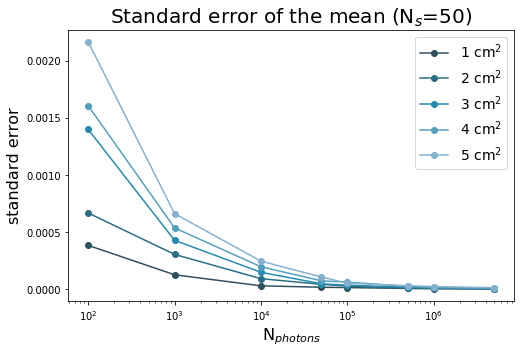

In [5]:
# iterate to find convergence (expect to take ~ 3 minutes)
startT = time.time()
Ns=50 # sample size
sides = np.array([1.,2.,3.,4.,5.])
Nphotons = np.array([1e2,1e3,1e4,5e4,1e5,5e5,1e6,5e6])
standarderror = np.empty((len(sides),len(Nphotons)))
viewfactor = np.empty((len(sides),len(Nphotons)))
i = 0
for s in sides:
    j = 0
    for N in Nphotons: 
        k=0
        F12s = np.empty(int(Ns))
        for iteration in np.linspace(1,Ns,Ns):
            F12s[k] = findF12(N,s)
            k+=1
        standarderror[i,j] = F12s.std() / np.sqrt(Ns)
        viewfactor[i,j] = F12s.mean()
        j+=1
    i+=1
# save into dataframe
stderr = pd.DataFrame(standarderror,columns=['1e2','1e3','1e4','5e4','1e5','5e5','1e6','5e6'], index=np.array([1,2,3,4,5]))
VF = pd.DataFrame(viewfactor,columns=['1e2','1e3','1e4','5e4','1e5','5e5','1e6','5e6'], index=np.array([1,2,3,4,5]))
endT = time.time()
print('time: '+str(endT-startT))

# PLOT
fig, ax = plt.subplots(figsize=(8,5))
custom_cycler = (cycler(color=sns.color_palette("PuBuGn_d",5)))
ax.set_prop_cycle(custom_cycler)
ax.semilogx(Nphotons,stderr.iloc[0].values,'o-')
ax.semilogx(Nphotons,stderr.iloc[1].values,'o-')
ax.semilogx(Nphotons,stderr.iloc[2].values,'o-')
ax.semilogx(Nphotons,stderr.iloc[3].values,'o-')
ax.semilogx(Nphotons,stderr.iloc[4].values,'o-')
ax.legend(['1 cm$^2$','4 cm$^2$','9 cm$^2$','16 cm$^2$','25 cm$^2$'],fontsize=14)
ax.set_title('Standard error of the mean (N$_s$=50)',fontsize=20)
ax.set_xlabel('N$_{photons}$',fontsize=16)
ax.set_ylabel('standard error', fontsize=16)
plt.rcParams.update({'font.size': 12})

# Compare to 6-13 in Mills & Coimbra

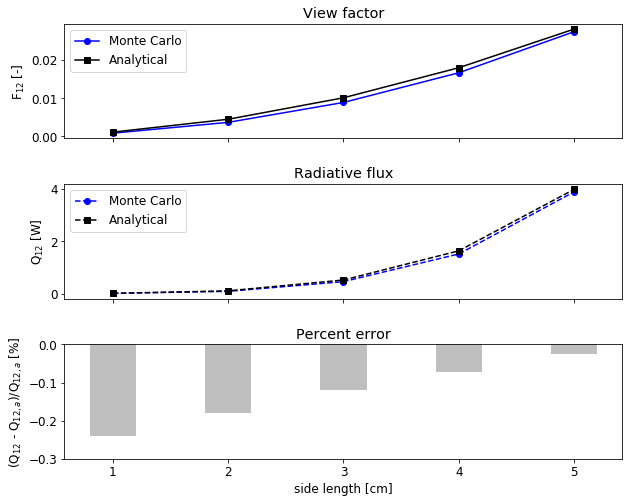

In [8]:
sides = [1.,2.,3.,4.,5.]
MCF = np.empty(5)
bkF = np.empty(5)
MCQ = np.empty(5)
bkQ = np.empty(5)
errors = np.empty(5)

i=0
for s in sides:
    F12 = findF12(1e6,s)
    bookF, bookQ = getbookQ(s*0.01)
    Q = getQfromF(F12,s*0.01)
    error = (Q-bookQ) / bookQ
    MCF[i] = F12
    MCQ[i] = Q
    bkF[i] = bookF
    bkQ[i] = bookQ
    errors[i] = error
    i+=1

# PLOT
fig, ax = plt.subplots(3,1,figsize=(10,8),sharex=True)
ax[0].plot(sides,MCF,'bo-',label='Monte Carlo')
ax[0].plot(sides,bkF,'ks-',label='Analytical')
ax[0].legend()
ax[0].legend(loc='upper left')
ax[0].set_ylabel('F$_{12}$ [-]')

ax[1].plot(sides,MCQ,'bo--',label='Monte Carlo')
ax[1].plot(sides,bkQ,'ks--',label='Analytical')
ax[1].legend(loc='upper left')
ax[1].set_ylabel('Q$_{12}$ [W]')

ax[2].bar(sides,errors,alpha=0.5,width=0.4,color='gray')
ax[2].set_ylim(-0.3,0)
ax[2].set_xlabel('side length [cm]')
ax[2].set_ylabel('(Q$_{12}$ - Q$_{12,a}$)/Q$_{12,a}$ [%]')

ax[0].set_title('View factor')
ax[1].set_title('Radiative flux')
ax[2].set_title('Percent error')

plt.subplots_adjust(hspace=0.4)
plt.rcParams.update({'font.size': 12})
plt.show()